In [1]:
import sys
sys.path.append("../../../")

In [2]:
import numpy as np
from scipy.constants import m_p, c, e

In [3]:
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap

PyHEADTAIL v1.2.0-122-g056083c437-dirty




In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# general simulation parameters
n_turns = 20000
n_particles = 10000
n_segments = 1

# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 5.9 # in [m]
inj_beta_y = 5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focussing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
eta = alpha_c_array[0] - gamma**-2
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
turn_period = circumference / (beta * c)

# BETATRON
# Loop on number of segments and create the TransverseSegmentMap
# for each segment.
s = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x = inj_alpha_x * np.ones(n_segments)
beta_x  = inj_beta_x * np.ones(n_segments)
D_x     = np.zeros(n_segments)
alpha_y = inj_alpha_y * np.ones(n_segments)
beta_y  = inj_beta_y * np.ones(n_segments)
D_y     = np.zeros(n_segments)

In [6]:
def plot_phase_space(bunch):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
    # phase spaces
    ax0.scatter(bunch.x, bunch.xp)
    ax1.scatter(bunch.y, bunch.yp)
    ax2.scatter(bunch.z, bunch.dp)
    # statistical quantities
    ax0.scatter(bunch.mean_x(), bunch.mean_xp(), color='red')
    ax1.scatter(bunch.mean_y(), bunch.mean_yp(), color='red')
    ax2.scatter(bunch.mean_z(), bunch.mean_dp(), color='red')
    plt.show()

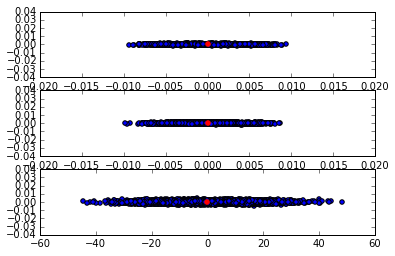

In [7]:
bunch = generators.Gaussian6DTwiss( # implicitly tests Gaussian and Gaussian2DTwiss as well
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_beta_x, epsn_x,
    inj_alpha_y, inj_beta_y, epsn_y, 
    beta_z, epsn_z
    ).generate()
plot_phase_space(bunch)

In [8]:
# Gaussian6D

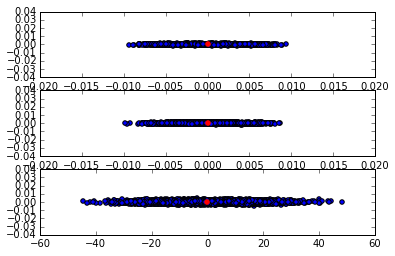

In [9]:
bunch = generators.ImportDistribution(
    n_particles, intensity, e, m_p, circumference, gamma,
    bunch.get_coords_n_momenta_dict()
    ).generate()
plot_phase_space(bunch)

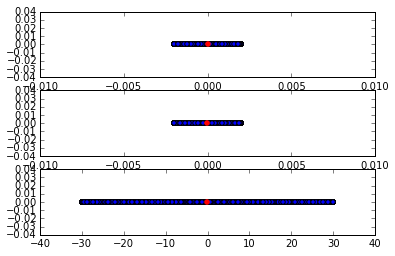

In [10]:
bunch = generators.Uniform3D(
    n_particles, intensity, e, m_p, circumference, gamma,
    2e-3, 2e-3, 30
    ).generate()
plot_phase_space(bunch)

In [11]:
transverse = TransverseMap(circumference, s, alpha_x, beta_x, D_x, alpha_y,
                           beta_y, D_y, Qx, Qy)
longitudinal = LinearMap(alpha_c_array, circumference, Qs)

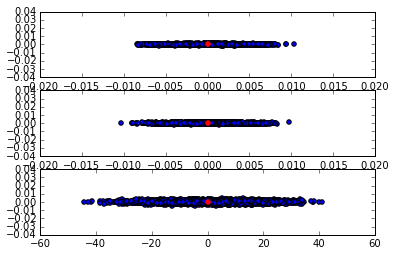

In [12]:
bunch = generators.MatchGaussian6D( # implicitly tests MatchLinearLongMap and MatchTransverseMap
    n_particles, intensity, e, m_p, circumference, gamma,
    transverse, epsn_x, epsn_y, longitudinal, epsn_z
    ).generate()
plot_phase_space(bunch)

In [13]:
rfsystems = RFSystems(circumference, [harmonic], [V_rf], [phi_offset],
                      alpha_c_array, gamma)

*** Maximum RMS emittance 4.50589180434eV s.
... distance to target emittance: 7.72e-02
... distance to target emittance: 7.75e-02
... distance to target emittance: -4.08e-05
--> Emittance: 1.20000000151
--> Bunch length:11.8086653152


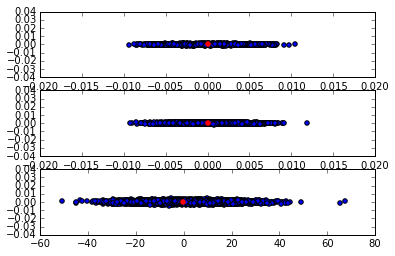

In [14]:
bunch = generators.MatchRFBucket6D( # implicitly tests MatchRFBucket2D and MatchTransverseMap
    n_particles, intensity, e, m_p, circumference, gamma,
    transverse, epsn_x, epsn_y, rfsystems.get_bucket(gamma=gamma), epsn_z
    ).generate()
plot_phase_space(bunch)

*** Maximum RMS emittance 4.50589180434eV s.
... distance to target emittance: 7.72e-02
... distance to target emittance: 7.75e-02
... distance to target emittance: -4.08e-05
--> Emittance: 1.20000000151
--> Bunch length:11.8086653152


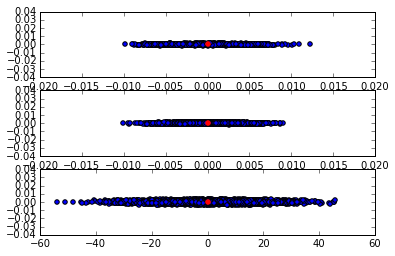

In [15]:
bunch = generators.Gaussian6DTwiss(
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_beta_x, epsn_x,
    inj_alpha_y, inj_beta_y, epsn_y, beta_z, epsn_z
    ).generate()
generators.MatchRFBucket2D(
    n_particles, intensity, e, m_p, circumference, gamma,
    rfsystems.get_bucket(gamma=gamma), epsn_z=epsn_z
    ).update(bunch)
plot_phase_space(bunch)

Reiterate on non-accepted particles
Reiterate on non-accepted particles


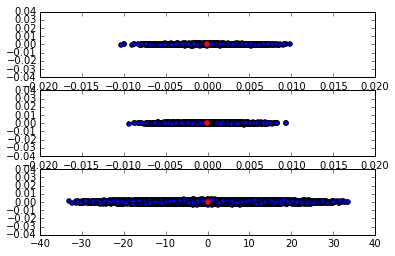

In [17]:
sigma_z = np.sqrt(beta_z * e * epsn_z / (4. * np.pi * p0))
sigma_dp = sigma_z / beta_z

bunch = generators.CutRFBucket6D( # implicitly tests CutRFBucket2D as well.
    n_particles, intensity, e, m_p, circumference, gamma,
    transverse, epsn_x, epsn_y, sigma_z, sigma_dp,
    rfsystems.get_bucket(gamma=gamma).make_is_accepted(0.6)
    ).generate()
plot_phase_space(bunch)

In [18]:
coords_n_momenta_dict = bunch.get_coords_n_momenta_dict()
coords_n_momenta_dict['x'] = np.append(coords_n_momenta_dict['x'], 0)
try:
    bunch = generators.ImportDistribution(
        n_particles, intensity, e, m_p, circumference, gamma,
        coords_n_momenta_dict
        ).generate()
    print ('test FAILED. Expected ValueError was not raised!')
except ValueError as exc:
    print ('test passed.\n')
    print ('Error message:\n' + exc.message)

test passed.

Error message:
lengths of given phase space coordinate arrays do not coincide with self.macroparticlenumber.


In [19]:
# Test particles.add method.
# Test I: Should not be allowed to overwrite existing coords with .add method.
# Test II: Should be able to add 'new' coords.
bunch = generators.Gaussian6DTwiss(
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_beta_x, epsn_x,
    inj_alpha_y, inj_beta_y, epsn_y, 
    beta_z, epsn_z
    ).generate()
x = np.random.randn(bunch.macroparticlenumber)
xp = np.random.randn(bunch.macroparticlenumber)
xx = np.random.randn(bunch.macroparticlenumber)
xxp = np.random.randn(bunch.macroparticlenumber)
coords_momenta_dict_to_add = {'x': x, 'xp': xp, 'xx': xx, 'xxp': xxp}

# Try to add coords_n_momenta that already exist in the bunch.
try:
    bunch.add(coords_momenta_dict_to_add)
    print ('Test FAILED. Expected ValueError was not raised!')
except ValueError as exc:
    print ('Test I passed.')
    print ('Error message:\n' + exc.message)
    print ('')
    
# Add coords_n_momenta which are new to the bunch. Should not give error message.
try:
    bunch.add({'xx': xx, 'xxp': xxp})
    bunch.xx
    bunch.xxp
    print ('Test II passed.\n')
except Exception as exc:
    print ('Test II FAILED. No error expected, but got message:\n' + exc.message)

Test I passed.
Error message:
One or more of the specified coordinates or momenta already exist and cannot be added. Use self.update(...) for this purpose.

Test II passed.



In [20]:
# Test particles.update method.
bunch = generators.Gaussian6DTwiss(
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_beta_x, epsn_x,
    inj_alpha_y, inj_beta_y, epsn_y, 
    beta_z, epsn_z
    ).generate()
x = np.random.randn(bunch.macroparticlenumber)
xp = np.random.randn(bunch.macroparticlenumber)
xx = np.random.randn(bunch.macroparticlenumber)
xxp = np.random.randn(bunch.macroparticlenumber)
coords_momenta_dict_to_update = {'x': x, 'xp': xp, 'xx': xx, 'xxp': xxp}

try:
    bunch.update(coords_momenta_dict_to_update)
    bunch.xx
    bunch.xxp
    print ('Test passed.\n')
except Exception as exc:
    print ('Test FAILED. No error expected, but got message:\n' + exc.message)    

Test passed.

